In [1]:
# SCREAM as example for paper figures
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
from scipy import stats
from utility import analysis_parameters as ap
from matplotlib.gridspec import GridSpec
import pandas as pd

import dask
# from dask.diagnostics import ProgressBar
# pbar = ProgressBar()
# pbar.register()

model="SCREAM"
region="TWP"
chunks={"ncol":1200, "time":8}
ndays=10
modcolors = ap.COLORS


# TWP plots
1. vertical profiles of RH, temperature, and IWC in height and temperature vertical coordinates
2. streamfunction with CRH
3. CRH/IWP percentiles with cloud fraction/IWC
4. ice number content in IWP space
5. get cloud base height/temp and cloud top height/temp
plot histogram of cld base/top height/temp
histogram of cld base when cirrus are present
flag columns with cirrus only 
6. for TTL cirrus, histograms of cloud base height/temp
and relative humidity correlation with in/above cloud


### functions

In [3]:
# functions
def get_esi(t):
    return (611.21 * np.exp(22.587*t/(t+273.86)))

def get_es(t):
    return (610.94 * np.exp(17.625*t/(t+243.04)))

def get_qs(es, p):
    return 0.622*es/p

def q2rhi(t, p, q, **kwargs):
    """
    Returns xarray of relative humidity wrt ice
    rhi = q/qs*100
    qsi = 0.622*es/P
    esi = 611.21 exp(22.587*T/(T+273.86)) for T <  0C
    """
    t = t - 273.15 # convert to deg C
    esi = get_esi(t)
    qsi = get_qs(esi, p)
    rh = q/qsi * 100
    return rh

def q2rh(t, p, q, **kwargs):
    """
    Returns xarray of relative humidity wrt liquid
    rh = q/qs*100
    qs = 0.622*es/P
    es = 610.94 exp(17.625*T/(T+243.04)) for T >= 0C
    """
    t = t - 273.15 # convert to deg C
    es = get_es(t)
    qs = get_qs(es, p)
    rh = q/qs * 100
    return rh

def q2wc(t, p, q, qi, **kwargs):
    """
    Returns xarray of ice or liquid water content
    iwc = qi * rho
    """
    rho = calc_rho(t, p, q)
    return (qi*rho)
    
def pot_temp(t, p):
    """ Returns potential temperature (theta in K)
        Input t (K) and p (Pa)
    """
    Rd = 287 # J/K/kg
    cp = 1004 # J/K/kg
    theta = t * np.power(100000/p, Rd/cp)
    return theta

def eq_pot_temp(t, p, q):
    """ Returns equivalent potential temperature (thetae in K)
        Input t (K), p (Pa) and q (kg/kg)
    """
    theta = pot_temp(t,p)
    Lv = 2.25e6 # J/kg
    cp = 1004 # J/K/kg
    qsi = get_qsi(get_esi(t), p)
    thetae = theta * np.exp(Lv * qsi / (cp * t) )
    return thetae
    
def crh_percentiles(t, p, q, lev="lev", bins = np.arange(0,101,4), return_crh=False):
    """
    Integreate column realitive humidity then bin by percentiles.
    Bins are 0-100 by 1s. Returns bin edges and crh_percentiles as
    mid_bin values. 
    
    Returns: bins, crh_percs
        if return_crh is True, returns (crh, (bins, crh_percs))
        
    TODO: crh = column integrated wv to saturatation wv
    """
    qs = get_qs(get_es(t), p)
    q_int = q.integrate("lev")
    qs_int = qs.integrate("lev")
    crh = q_int/qs_int
    print("shape of crh:", crh.shape)
    crh_percs = np.zeros(crh.shape)
    
    for i in range(len(bins)-1):
        perc_thres_lower = np.nanpercentile(crh, bins[i])
        perc_thres_upper = np.nanpercentile(crh, bins[i+1])
        crh_percs = np.where((crh>=perc_thres_lower)&(crh<perc_thres_upper), 
                             (bins[i]+bins[i+1])/2, crh_percs)
    crh_percs = xr.DataArray(crh_percs, dims=crh.dims, coords=crh.coords, 
                             attrs={"long_name":"column relative humidity binned percentiles","units":"%"})
    if return_crh:
        return crh, (bins, crh_percs)
    else:
        return bins, crh_percs
    return bins, crh_percs

def stream_function(omega, crh_perc, bins, return_omega=False):
    """
    Calculate the mean profiles for given omega (Pa/s)
    for each CRH percentile bin.
    
    Input:  vertical velocity (omega, unit: Pa/s),  
            column relative humidity percentiles (crh_perc, unit: %),
            bin edges (bins, unit: %) same as from crh_percentiles.
            
    Output: stream function (phi_rp) in coordinates of CRH and pressure.
                should be of shape (100, nlevs)
            if return_omega is True, returns (w_rp, phi_rp) as tuple
            
    """
    w_rp   = np.zeros((len(bins)-1, omega.shape[1])) # shape of crh mid_bins and pres levels
    phi_rp = np.zeros((len(bins)-1, omega.shape[1])) # shape of crh mid_bins and pres levels
    for i in range(20, len(bins)-1):
        w_rp[i,:] = omega.where((crh_perc>= bins[i])&(crh_perc<bins[i+1])).mean(skipna=True, dim=["time","ncol"])
        alpha = 1 # 0.01
        if (i==20):
            phi_rp[i,:] = alpha/9.8*w_rp[i,:]
        else:
            phi_rp[i,:] = phi_rp[i-1]+ alpha/9.8*w_rp[i,:] 
    if return_omega:
        return phi_rp, w_rp
    return phi_rp

def binned_by_crh(var, crh_perc, bins):
    """
    Calculate the mean profiles for given variable
    for each CRH percentile bin.
    
    Input:  variable (e.g., qi, unit: kg/kg),  
            column relative humidity percentiles (crh_perc, unit: %),
            bin edges (bins, unit: %) same as from crh_percentiles.
            
    Output: binned_var (var_r) in coordinates of CRH and pressure.
                should be of shape (100, nlevs)
            
    """
    var_r = np.zeros((len(bins)-1, var.shape[1])) # shape of crh mid_bins and pres levels
    for i in range(len(bins)-1):
        var_r[i,:] = var.where((crh_perc>= bins[i])&(crh_perc<bins[i+1])).mean(skipna=True, dim=["time","ncol"])
    return var_r

def calc_rho(t, p, q):
    Tv = (1 + 0.61*q)*t
    rho = p / (287*Tv)
    return rho

def w2omega(t, p, q, w):
    rho = calc_rho(t, p, q)
    g=9.8 #m/s2
    omega = -rho*g*w # (kg/m/s2)/s = Pa/s
    return omega

def omega2w(t, p, q, omega):
    rho = calc_rho(t, p, q)
    g=9.8
    w = -omega/(rho*g) # m/s
    return w

def get_lwcre(olr, olrcs):
    lwcre = olrcs.values - olr
    return lwcre

def get_swcre(alb, albcs):
    swcre = -(alb-albcs)*413.2335274324269 #twp
    return swcre

### load variables

In [11]:
# load temp, wv, pres, and height
# 3D variable
t = xr.open_dataset(ap.get_file(model, region+"_3D", "ta"), 
                    chunks=chunks).isel(time=slice(-8*ndays,-1)).ta[:,1:]
p = t.lev*100 # convert to Pa
qv = xr.open_dataset(ap.get_file(model, region+"_3D", "hus"), 
                    chunks=chunks).isel(time=slice(-8*ndays,-1)).hus[:,1:]

z = xr.open_dataset(ap.get_file(model, region+"_3D", "zg"), 
                    chunks=chunks).isel(time=slice(-8*ndays,-1)).zg
z_plot = z.mean(axis=(0,2))

iwc = xr.open_dataset(ap.get_file(model, region+"_3D", "totalwater"),
                      chunks=chunks).isel(time=slice(-8*ndays,-1)).totalwater[:,1:]
iwc

<xarray.DataArray 'totalwater' (time: 79, lev: 127, ncol: 61250)>
dask.array<getitem, shape=(79, 127, 61250), dtype=float32, chunksize=(8, 127, 1200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2020-02-19 00:00:00 ... 2020-02-28 18:00:00
    lon      (ncol) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    lat      (ncol) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
  * lev      (lev) float64 3.23 3.88 4.597 5.473 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    standard_name:  mass_fraction_of_cloud_ice_in_air
    long_name:      Grid box averaged cloud ice amount
    units:          kg m-3
    CDI_grid_type:  unstructured
    mdims:          1
    origin:         CLDICE

In [5]:
# calculate RH
rhi = q2rhi(t, p, qv)
rhi

[########################################] | 100% Completed | 101.51 ms
[########################################] | 100% Completed | 103.33 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 103.05 ms


<xarray.DataArray (time: 79, lev: 127, ncol: 61250)>
dask.array<mul, shape=(79, 127, 61250), dtype=float64, chunksize=(8, 127, 1200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2020-02-19 00:00:00 ... 2020-02-28 18:00:00
    lon      (ncol) float64 143.0 143.1 143.0 143.1 ... 143.8 143.9 143.9 143.9
    lat      (ncol) float64 -4.974 -4.977 -4.939 -4.942 ... 4.993 4.995 4.998
  * lev      (lev) float64 3.23 3.88 4.597 5.473 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol

In [4]:
# 2D variable
# cth = xr.open_dataset(ap.get_file(model, region,"cldtop_height"), 
#                       chunks=chunks).isel(time=slice(-8*ndays,-1))
# cth_idx = cth["cldtop_ind1e-06"]
# cth = cth["cldtop_height1e-06"]

iwp = xr.open_dataset(ap.get_file(model, region, "clivi")).isel(time=slice(-96*ndays,-1)).clivi
iwp_expand = iwp.expand_dims({"lev":127},axis=1).sel(time=t.time)

olr = ap.load_olr(model, region).isel(time=slice(-96*ndays,-1))
alb = ap.load_alb(model, region).isel(time=slice(-96*ndays,-1))

print(olr.shape, alb.shape, 
      # twc.shape, 
      # icenvi.shape,
      # cth.shape, cth_idx.shape, 
      z.shape, p.shape, t.shape)
print(olr.time[5*12].values, t.time[5].values)

False
returning swn all sky
[########################################] | 100% Completed | 1.22 sms
(959, 61250) (959, 61250) (79, 127, 61250) (127,) (79, 127, 61250)
2020-02-19 15:00:00 2020-02-19 15:00:00


In [5]:
# calculate lw and sw cre

olrcs = xr.open_dataset(ap.get_file(model, region, "rltcs")).isel(time=slice(-96*ndays,-1)).rltcs
albcs = ap.load_alb(model, region, clearsky=True).isel(time=slice(-96*ndays,-1))

print(alb.time[0].values, albcs.time[0].values, alb.dims, albcs.dims)

lwcre = get_lwcre(olr, olrcs)
lwcre = lwcre.compute()
swcre = get_swcre(alb, albcs.values)
swcre = swcre.where((swcre.time.dt.hour<=6)|(swcre.time.dt.hour>=22)).compute()
netcre = lwcre+swcre.values
del olrcs, albcs

True
returning cs swu
[########################################] | 100% Completed | 101.39 ms
[########################################] | 100% Completed | 103.78 ms
[########################################] | 100% Completed | 101.15 ms
[########################################] | 100% Completed | 103.65 ms
[########################################] | 100% Completed | 604.91 ms
2020-02-19 00:00:00 2020-02-19 00:00:00 ('time', 'ncol') ('time', 'ncol')
[########################################] | 100% Completed | 611.20 ms
[########################################] | 100% Completed | 814.37 ms
[########################################] | 100% Completed | 1.12 sms


In [6]:
del olr, alb

## Plots

In [1]:
# swcre.mean(axis=1).plot(marker='.')
# lwcre.mean(axis=1).plot()
# netcre.mean(axis=1).plot()
# plt.show()


### vertical profiles of temperature, RHi and cloud ice

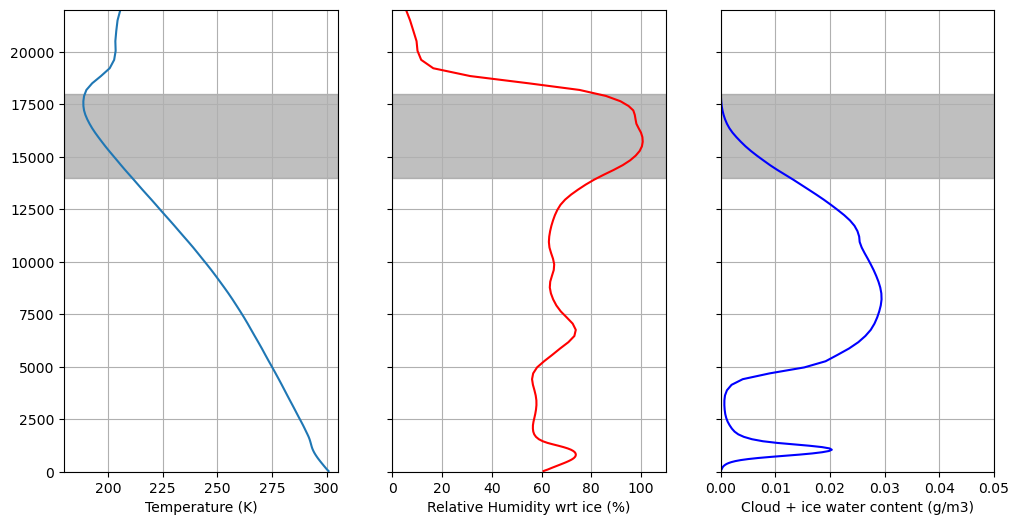

In [5]:
# plot temperature, relative humidity, and cloud ice in height coordinates

fig, ax = plt.subplots(1,3, figsize=(12,6), sharey=True)
ax[0].plot(t.mean(axis=(0,2)), z_plot)
ax[1].plot(rhi.mean(axis=(0,2)), z_plot, label="rh", color="red")
ax[2].plot(twc.mean(axis=(0,2))*1000, z_plot, label="iwc+lwc", color="blue")
xlims = [(180,305),(0,110),(0,0.05)]
xlabels= ["Temperature (K)", "Relative Humidity wrt ice (%)", "Cloud + ice water content (g/m3)"]
for i in range(3):
    ax[i].fill_between(xlims[i],14000,18000, color='gray', alpha=0.5)
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_xlim(xlims[i])
    ax[i].set_ylim([0,22000])
    ax[i].grid(True)
plt.savefig("../plots/{}_{}_last{}days_t-rhi-qi.png".format(region, model, ndays))
plt.show()

### Similar to above but plotting in theta space (K) instead of height (m)

[########################################] | 100% Completed | 1.22 sms
[########################################] | 100% Completed | 55.22 s
[########################################] | 100% Completed | 6.66 ss
[########################################] | 100% Completed | 3.03 sms
[########################################] | 100% Completed | 1.92 sms
[########################################] | 100% Completed | 1.72 sms


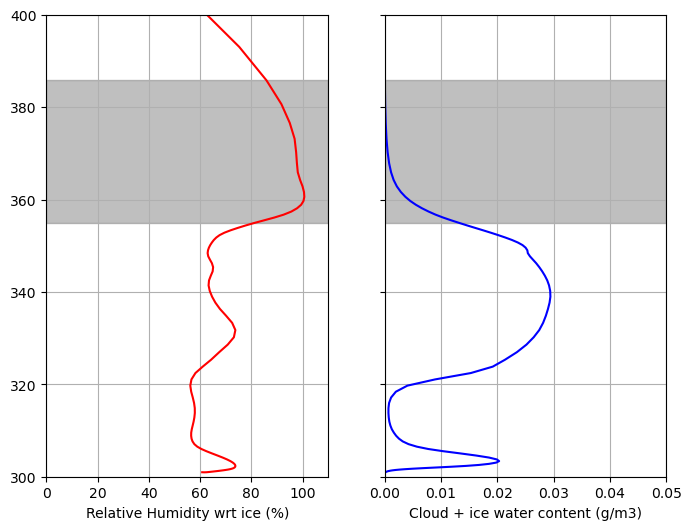

In [13]:
# plot relative humidity and cloud ice in temperature coordinates
theta = pot_temp(t, p).mean(axis=(0,2)).values

fig, ax = plt.subplots(1,2, figsize=(8,6), sharey=True)
ax[0].plot(rhi.mean(axis=(0,2)), theta, label="rh", color="red")
ax[1].plot(twc.mean(axis=(0,2))*1000, theta, label="iwc", color="blue")
xlims = [(0,110),(0,0.05)]
xlabels= ["Relative Humidity wrt ice (%)", "Cloud + ice water content (g/m3)"]
for i in range(2):
    ax[i].fill_between(xlims[i],theta[np.argmin(abs(z_plot.values-14000))],
                       theta[np.argmin(abs(z_plot.values-18000))], color='gray', alpha=0.5)
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_xlim(xlims[i])
    ax[i].set_ylim([300,400])
    ax[i].grid(True)
# plt.savefig("../plots/{}_{}_last{}days_theta-rhi-qi.png".format(region, model, ndays))
plt.show()

### Stream function

1. calculate stream function in CRH percentiles
2. plot stream function and RHice binned by CRH percentiles

In [ ]:
# stream function
# calculate crh percentiles
bins, crh_percs = crh_percentiles(t, p, q)
omega = xr.open_dataset(ap.get_file(model, region+"_3D", "wap")).isel(time=slice(-8*ndays,-1)).wap
omega = omega[:,1:]
print(omega.shape)

[########################################] | 100% Completed | 202.66 ms
[########################################] | 100% Completed | 103.25 ms
[########################################] | 100% Completed | 101.57 ms
[########################################] | 100% Completed | 204.31 ms
shape of crh: (23, 61250)
[########################################] | 100% Completed | 3.77 ss
[########################################] | 100% Completed | 1.88 sms
[########################################] | 100% Completed | 2.15 sms
[########################################] | 100% Completed | 2.31 sms
[########################################] | 100% Completed | 2.38 sms
[########################################] | 100% Completed | 2.10 sms
[########################################] | 100% Completed | 1.98 sms
[########################################] | 100% Completed | 1.90 sms
[########################################] | 100% Completed | 1.87 sms
[########################################] | 100

In [ ]:
# calculate stream function, phi
phi = stream_function(omega, crh_percs, bins)

In [ ]:
# bin rhi by column relative humidity
rhi_r = binned_by_crh(rhi, crh_percs, bins)

In [ ]:
# plot stream function in black contours with rhi in colormap
# all binned by column relative humidity
fig, ax = plt.subplots(1,1, figsize=(6,6))
bin_mid = (bins[:-1]+bins[1:])/2
pc = ax.contour(bin_mid, z_plot, phi.T, colors="k", levels=6)
pci = ax.contourf(bin_mid, z_plot, rhi_r.T, cmap="gist_earth_r")
ax.set_ylim([0, 20000])
# ax.fill_between([0, 100], 14000, 18000, color='gray', alpha=0.5)
ax.set_xlim([0,100])
ax.set_xlabel("CRH percentiles")
plt.colorbar(pci, ax=ax, label="RH wrt ice")
ax.clabel(pc, pc.levels, inline=True, fontsize=10)
plt.savefig("../plots/{}_{}_streamfunction-qi.png".format(region, model))
plt.show()

### IWP percentiles

1. calculate iwp percentiles
2. bin olr, iwp, albedo, and ice number by iwp percentiles
3. plot

In [14]:
# calculate iwp percentiles
# may as well bin rhi by iwp right now too
bins = np.arange(0,100.1,4)
iwp_bins = np.zeros(26)
iwp_percs = np.zeros(iwp.shape)
twc_iwp = np.zeros((len(bins)-1, t.shape[1]))
lwcre_iwp = np.zeros(len(bins)-1)
swcre_iwp = np.zeros(len(bins)-1)
netcre_iwp = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    perc_thres_lower = np.nanpercentile(iwp, bins[i])
    perc_thres_upper = np.nanpercentile(iwp, bins[i+1])
    if i==0:
        iwp_bins[0] = perc_thres_lower
        iwp_bins[1] = perc_thres_upper
    else:
        iwp_bins[i+1] = perc_thres_upper
    print(i, perc_thres_upper)
    iwp_percs = np.where((iwp>=perc_thres_lower)&(iwp<perc_thres_upper), 
                         (bins[i]+bins[i+1])/2, iwp_percs)
    twc_iwp[i,:] = iwc.where((iwp_expand>=perc_thres_lower)&(iwp_expand<perc_thres_upper)).mean(skipna=True, axis=(0,2))
    lwcre_iwp[i] = np.nanmean(np.where((iwp>=perc_thres_lower)&(iwp<perc_thres_upper), 
                                     lwcre, np.nan))
    swcre_iwp[i] = np.nanmean(np.where((iwp>=perc_thres_lower)&(iwp<perc_thres_upper), 
                                     swcre, np.nan))
    netcre_iwp[i] = np.nanmean(np.where((iwp>=perc_thres_lower)&(iwp<perc_thres_upper), 
                                     netcre, np.nan))
    # icenvi_iwp[i] = np.nanmean(np.where((iwp>=perc_thres_lower)&(iwp<perc_thres_upper), 
    #                                  icenvi, np.nan))

0 4.7071754671890175e-09
[########################################] | 100% Completed | 101.50 ms
[########################################] | 100% Completed | 101.30 ms
[########################################] | 100% Completed | 13.51 s
1 3.493637368592317e-06
[########################################] | 100% Completed | 101.52 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 15.12 s
2 1.6976566548692063e-05
[########################################] | 100% Completed | 101.62 ms
[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 15.72 s
3 3.5163656139047814e-05
[########################################] | 100% Completed | 101.60 ms
[########################################] | 100% Completed | 101.31 ms
[########################################] | 100% Completed | 15.91 s
4 5.73819037526846e-05
[#####################

In [15]:
# plot iwc in iwp space 
# along with olr and albedo
# next, plot ice crystal number amount in iwp space


In [19]:
twc_iwp.shape

(25, 127)

[########################################] | 100% Completed | 5.85 ss
[########################################] | 100% Completed | 4.03 sms
[########################################] | 100% Completed | 3.93 sms


/tmp/ipykernel_248199/3162852540.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  pci = ax[0].contourf(bin_mid, z_plot, (twc_iwp.T)*1000, levs,


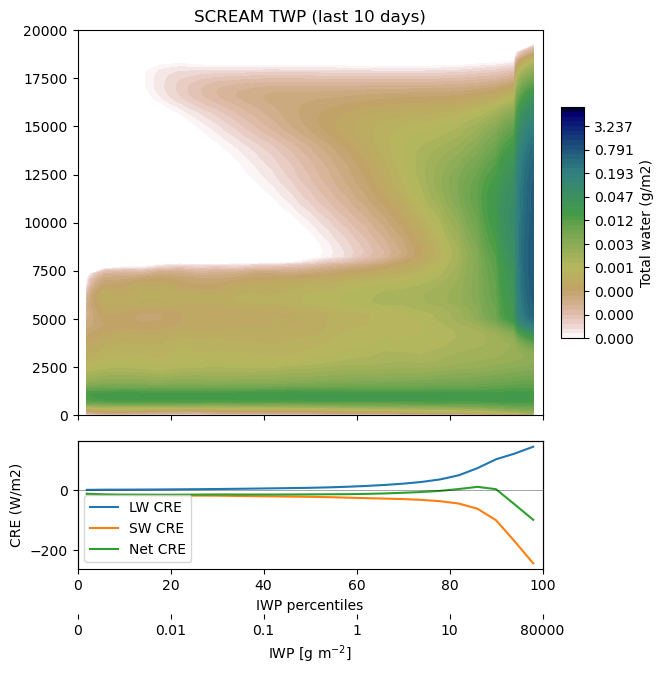

In [33]:
# plot IWC in iwp space 
fig, ax = plt.subplots(2,1, figsize=(6,7), sharex=True, 
                       gridspec_kw={'height_ratios': [3, 1], 'hspace':0.1})
bin_mid = (bins[:-1]+bins[1:])/2
## axis 0 - iwc in iwp space
levs = np.logspace(-5,1)
# levs = np.linspace(40,110,15)
pci = ax[0].contourf(bin_mid, z_plot, (twc_iwp.T)*1000, levs, 
                     # cmap="viridis",
                     cmap="gist_earth_r", norm=colors.LogNorm()) 
ax[0].set(ylim=[0, 20000], xlim=[0,100])
cax = ax[0].inset_axes([1.04, 0.2, 0.05, 0.6])
plt.colorbar(pci, cax=cax, label="Total water (g/m2)", shrink=0.5) #RHice (%)
## axis 1 - mean olr,alb,lwp in iwp space 
ax[1].plot(bin_mid, lwcre_iwp, color="C0", label="LW CRE")
ax[1].set(xlabel="IWP percentiles", ylabel="CRE (W/m2)")
ax[1].plot(bin_mid, swcre_iwp, color="C1", label="SW CRE")
ax[1].plot(bin_mid,netcre_iwp, color="C2", label="Net CRE")
ax[1].axhline(0,0,100,color='k',alpha=0.5, lw=0.5)

ax2 = ax[1].twiny()
new_tick_locations =bins[::5] #xbin_perc
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.set_xticks(new_tick_locations)
iwp_bins_plot=[0,1e-2,1e-1,1,10,80000]
ax2.set_xticklabels(iwp_bins_plot)
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.35))
ax2.spines['bottom'].set_visible(False)
ax2.set_xlabel('IWP [g m$^{-2}$]')

ax[1].legend()
ax[0].set_title("{} {} (last {} days)".format(model, region, ndays))
plt.savefig("../plots/{}_{}_iwc_cre_iwp-space.png".format(region, model), bbox_inches="tight", pad_inches=1)
plt.show()

In [27]:
iwp_bins[::5]*1000
iwp_bins_plot=[None,1e-2,1e-1,1,10,None]

array([0.00000000e+00, 5.73819038e-02, 2.90660362e-01, 1.33271699e+00,
       1.30442742e+01, 8.58662338e+04])

[########################################] | 100% Completed | 101.21 ms
[########################################] | 100% Completed | 101.70 ms


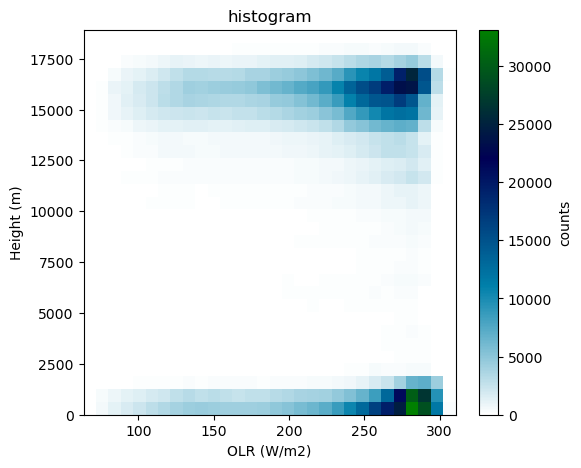

In [26]:
## get cloud top height and temperature
fig, ax = plt.subplots(1,1, figsize=(6,5))
_,_,_,im = ax.hist2d(olr.values.flatten(), cth.values.flatten(), 
                     bins=30, cmap="ocean_r")
ax.set(xlabel="OLR (W/m2)", ylabel="Height (m)", title="histogram")
plt.colorbar(im, label="counts")
plt.show()

# tropical band - thick vs thin anvil

1. Convective core - IWP $> 1000$ g/m2
1. Thick anvil     - IWP $\in [100,1000)$
1. Intermediary    - IWP $\in [10, 100)$
1. Thin anvil      - IWP $\in [0.1, 10)$

In [2]:
# load IWP
nd=96
ndays=30
chunks = {"time":96, "lon":90}
model="UM"+"r1deg"
iwp = ap.load_iwp(model, "GT", total=True, chunks=chunks).isel(time=slice(-nd*ndays,-1))
iwp = iwp*1000
iwp

<xarray.DataArray 'clivi' (time: 2879, lat: 60, lon: 360)>
dask.array<mul, shape=(2879, 60, 360), dtype=float32, chunksize=(96, 60, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T00:15:00 ... 2020-02-28T23:45:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5

In [4]:
# categorize IWP into 4 categories
cat_count = np.zeros(5)
cat_count[1] = np.sum(np.where(iwp>=1000, 1, 0))
cat_count[2] = np.sum(np.where((iwp>=100)&(iwp<1000), 1, 0))
cat_count[3] = np.sum(np.where((iwp>=10)&(iwp<100), 1, 0))
cat_count[4] = np.sum(np.where((iwp>=0.1)&(iwp<10), 1, 0))
cat_count[0] = iwp.shape[0]*iwp.shape[1]*iwp.shape[2]
print(cat_count)
print(cat_count/cat_count[0]*100)

[62186400.   918865.  4036881.  9306068. 21507010.]
[100.           1.477598     6.49158176  14.96479616  34.58474843]


In [15]:
col_names = ["total", "conv", "thick", "med", "thin"]
# df = pd.DataFrame([cat_count], index=["{}r1deg".format(model)], 
#                   columns=col_names)

## save to a pandas dataframe
df = pd.read_csv("../stats/GT_IWP_categories_1e-1_10_100_1000.csv", index_col=0)
df

,total,conv,thick,med,thin
SCREAMr1deg,58039200.0,2062309.0,4378669.0,5663484.0,14676902.0
GEOSr1deg,62186400.0,1044412.0,5084320.0,7606355.0,17476549.0
SAMr1deg,62186400.0,24787.0,3552255.0,9335355.0,17610530.0
UMr1deg,62186400.0,918865.0,4036881.0,9306068.0,21507010.0
SHiELDr1deg,62186400.0,242791.0,5818630.0,11544135.0,17914161.0


In [16]:
df.loc[model] = cat_count
df

,total,conv,thick,med,thin
SCREAMr1deg,58039200.0,2062309.0,4378669.0,5663484.0,14676902.0
GEOSr1deg,62186400.0,1044412.0,5084320.0,7606355.0,17476549.0
SAMr1deg,62186400.0,24787.0,3552255.0,9335355.0,17610530.0
UMr1deg,62186400.0,918865.0,4036881.0,9306068.0,21507010.0
SHiELDr1deg,62186400.0,242791.0,5818630.0,11544135.0,17914161.0
ICONr1deg,61538400.0,9.0,1697702.0,10651618.0,19224902.0


In [17]:
df.to_csv("../stats/GT_IWP_categories_1e-1_10_100_1000.csv")

SCREAMr1deg
GEOSr1deg
SAMr1deg
UMr1deg
SHiELDr1deg
ICONr1deg


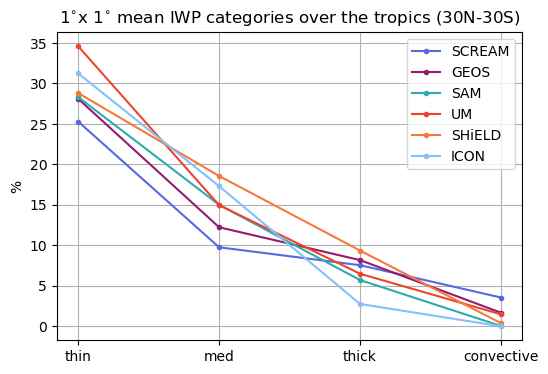

In [38]:
# plot it

df = pd.read_csv("../stats/GT_IWP_categories_1e-1_10_100_1000.csv", index_col=0)
df = df.T
models = list(df.keys())
fig, ax = plt.subplots(1,1,figsize=(6,4))
for m in models:
    print(m)
    ax.plot([1,2,3,4],np.array([df[m].thin, df[m].med, df[m].thick, df[m].conv])/df[m].total*100, color=modcolors[m.split("r")[0]], marker=".", label=m.split("r")[0])
ax.set(xticks=[1,2,3,4], xticklabels=["thin","med", "thick","convective"], 
       ylabel="%", title="$1^{\circ}$x $ 1^{\circ}$ mean IWP categories over the tropics (30N-30S)")
ax.legend()
ax.grid(True)
plt.show()